In [2]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack, hstack
from astropy.coordinates import SkyCoord

from PIL import Image

sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/script/')

In [34]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)

In [5]:
# we need to bootstrap to know the error of N_UDG

In [6]:
input_cuts_cat = Table.read('./Catalog/nsa_z001_004/lsbg_after_cuts_spergel_w_missed.fits')
from sample_cuts import post_process_cat_new_rbf
cuts_cat = post_process_cat_new_rbf(input_cuts_cat)

In [7]:
udg_cat = Table.read(
    '/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_004/udg_z001_004_spergel_after_viz_w_missed.fits')
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25)
udg_cat = udg_cat[flag]
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

In [8]:
fake_udg_cat = Table.read('./Catalog/random_field/fake_udg_cat_220726.fits')
fake_udg_cat = fake_udg_cat[fake_udg_cat['completeness'] > 0.1]
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

In [9]:
len(cuts_cat)

2510

---

In [14]:
# Roman17b: no completeness, they quote the contamination must be small, but no estimation
roman17b = [[11.858108108108109, 0.006651884700664468], 
            [12.015202702702704, 0.4789356984478932], 
            [12.85641891891892, 0.30598669623059793]]
roman17b_xerr = [[-0.43, 0.23], 
                 [0, 0], 
                 [-1.14, 0.284]]
roman17b_yerr = [[-0.399, 0.29], 
                 [-0.359, 0.206], 
                 [-0.55, 0.239]]

# Roman17a: no completeness, also no estimatino for contamination
roman17a = [[13.16554054054054, 1.0177383592017737],
            [14.244932432432432, 1.5432372505543237]]
roman17a_xerr = [[-0.294, 0.183], 
                 [-0.28, 0.15]]
roman17a_yerr = [[-0.14, 0.14], 
                 [-0.20, 0.206]]

# Koda: no completeness, but their contams might be small
koda = [14.91891891891892, 2.3082039911308208]
koda_xerr = 0.08
koda_yerr = 0.1

# No completeness and contams
Janssens = [[15.679054054054053, 3.33259423503326]]
Janssens_xerr = [[-0.375, 0.2]]
Janssens_yerr = [[-0.13, 0.12]]

Munoz = [14.047297297297298, 1.4501108647450112]
Munoz_xerr = 0.10
Munoz_yerr = 0.13


SAGA_mao = [np.log10(1.6e12), np.log10(6 / 36)]
SAGA_mao_xerr = 0.4
SAGA_mao_yerr = [[np.log10((6 - np.sqrt(6)) / 36) - np.log10(6 / 36), 
                  np.log10((6 + np.sqrt(6)) / 36) - np.log10(6 / 36)]]


ELVES = [12.1, np.log10(15 / 30)]
ELVES_xerr = 0.5
ELVES_yerr = [[np.log10((15 - np.sqrt(15)) / 30) - np.log10(15 / 30), 
                  np.log10((15 + np.sqrt(15)) / 30) - np.log10(15 / 30)]]

---
### Divide hosts into early and late type

In [15]:
_cuts_cat = cuts_cat
_udg_cat = _cuts_cat[np.in1d(_cuts_cat['viz-id'], udg_cat['viz-id'])]
_, ind = np.unique(_udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (_udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2  - (3/60)**2
print('Total angular area [deg2]:', total_area)
n_udg = (len(_udg_cat) - density_bkg * total_area) / len(np.unique(_cuts_cat['host_name']))
n_udg_std = np.sqrt(len(_udg_cat) - density_bkg * total_area) / len(np.unique(_cuts_cat['host_name']))

Total angular area [deg2]: 32.70887732960614


Total angular area [deg2]: 32.70887732960614
Total angular area [deg2]: 32.70887732960614
0.7633442809899098 0.04090235400770302
Total angular area [deg2]: 26.85687074655511
Total angular area [deg2]: 5.852006583051025
Total angular area [deg2]: 9.845408305681767
Total angular area [deg2]: 22.86346902392437


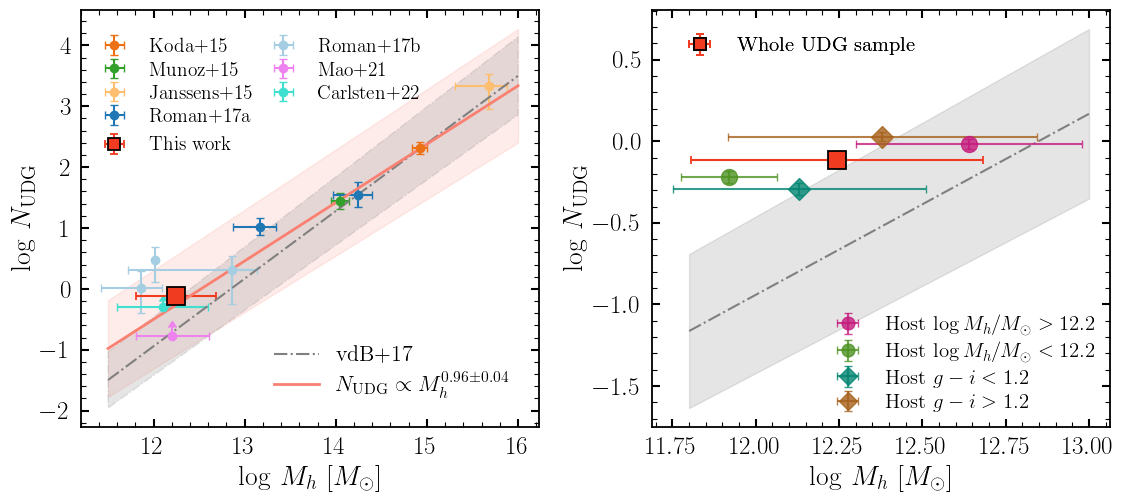

In [73]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(11.5, 5.3))

colors = ['#a6cee3','#1f78b4','#ec7014','#33a02c','#fdbf6f', 'violet', 'turquoise']
#['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854']

plt.sca(ax1)
plt.errorbar(*koda,
             xerr=koda_xerr,
             yerr=koda_yerr,
             fmt='o', label='Koda+15', color=colors[2])

plt.errorbar(*Munoz,
             xerr=np.array(Munoz_xerr),
             yerr=Munoz_yerr,
             fmt='o', label='Munoz+15', color=colors[3])

plt.errorbar(np.array(Janssens)[:, 0], np.array(Janssens)[:, 1], 
             xerr=np.abs(np.array(Janssens_xerr)).T,
             yerr=np.abs(np.array(Janssens_xerr)).T,
             fmt='o', label='Janssens+15', color=colors[4])


plt.errorbar(np.array(roman17a)[:, 0], np.array(roman17a)[:, 1], 
             xerr=np.abs(np.array(roman17a_xerr)).T,
             yerr=np.abs(np.array(roman17a_yerr)).T,
             fmt='o', label='Roman+17a', color=colors[1])

plt.errorbar(np.array(roman17b)[:, 0], np.array(roman17b)[:, 1], 
             xerr=np.abs(np.array(roman17b_xerr)).T,
             yerr=np.abs(np.array(roman17b_yerr)).T,
             fmt='o', label='Roman+17b', color=colors[0])

plt.errorbar(*SAGA_mao,
             xerr=np.array(SAGA_mao_xerr),
             yerr=np.abs(np.array(SAGA_mao_yerr)).T,
             lolims=True,
             fmt='o', label='Mao+21', color=colors[5])

plt.errorbar(*ELVES,
             xerr=np.array(ELVES_xerr),
             yerr=np.abs(np.array(ELVES_yerr)).T,
             lolims=True,
             fmt='o', label='Carlsten+22', color=colors[6])

##### Total sample #####
_cuts_cat = cuts_cat
_udg_cat = _cuts_cat[np.in1d(_cuts_cat['viz-id'], udg_cat['viz-id'])]
_, ind = np.unique(_udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (_udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2  - (3/60)**2
print('Total angular area [deg2]:', total_area)
n_udg = (len(_udg_cat) - density_bkg * total_area) / len(np.unique(_cuts_cat['host_name']))
n_udg_std = np.sqrt(len(_udg_cat) - density_bkg * total_area) / len(np.unique(_cuts_cat['host_name']))
n_udg *= (1 / _udg_cat['completeness']).mean()
n_udg_std *= (1 / _udg_cat['completeness']).mean()

m_vir = np.unique(_cuts_cat['host_halo_mass']).mean()
m_vir_std = np.unique(_cuts_cat['host_halo_mass']).std()
plt.errorbar(m_vir, 
             np.log10([n_udg]), 
             xerr=m_vir_std, 
             yerr=[np.log10([n_udg]) - np.log10([n_udg - n_udg_std]),
                   np.log10([n_udg + n_udg_std]) - np.log10([n_udg])],
             fmt='s', ms=13, color='#f03b20', markeredgecolor='k', markeredgewidth=1.3, label='This work')

# leg = plt.legend(loc=(0.02, 0.55), fontsize=15, markerscale=0.7)
# ax1.add_artist(leg)
h1, l1 = ax1.get_legend_handles_labels()
ax1.add_artist(ax1.legend(h1[0:-1], l1[0:-1], loc=(0.01, 0.7), ncol=2, fontsize=14, columnspacing=0.5))
ax1.add_artist(ax1.legend(h1[-1:], l1[-1:], loc=(0.01, 0.63), fontsize=14, markerscale=0.7))
# ax1.add_artist(ax1.legend(h1[0:-1], l1[0:-1], loc=(0.02, 0.53), fontsize=14))
# ax1.add_artist(ax1.legend(h1[-1:], l1[-1:], loc=(0.61, 0.11), fontsize=14, markerscale=0.7))

# vdb17
x = np.linspace(11.5, 16, 10)
line1 = plt.plot(x, 1.11 * x + np.log10(19) - 1.11 * 14, label='vdB+17', ls='-.', color='gray')
plt.fill_between(x, (1.11 + 0.04) * x + np.log10(19) - 1.11 * 14, 
                 (1.11 - 0.04) * x + np.log10(19) - 1.11 * 14, 
                 alpha=0.2, color='gray', interpolate=True, ls='-.', )
plt.legend(handles=[line1[0]], loc='lower right')


# my own fits
line2 = plt.plot(x, f(myoutput.beta, x), color='salmon', ls='-', lw=2,
                 label=r'$N_{\rm UDG}\propto M_h^{0.96\pm 0.04}$')
plt.fill_between(x, f(beta + beta_std, x), 
                 f(beta - beta_std, x), alpha=0.15, color='salmon', 
                 ls='-', interpolate=True, zorder=0)

plt.legend(handles=[line1[0], line2[0]], loc='lower right')


plt.xlabel(r'$\log\, M_{h}\ [M_\odot]$', fontsize=20)
plt.ylabel(r'$\log\, N_{\rm UDG}$', fontsize=20)
plt.xticks([12, 13, 14, 15, 16])
plt.tick_params(axis='both', which='major', labelsize=18)


##############################################################################
plt.sca(ax2)
x = np.linspace(11.8, 13, 10)
plt.plot(x, 1.11 * x + np.log10(19) - 1.11 * 14, ls='-.', color='gray')
plt.fill_between(x, (1.11 + 0.04) * x + np.log10(19) - 1.11 * 14, 
                 (1.11 - 0.04) * x + np.log10(19) - 1.11 * 14, 
                 alpha=0.2, color='gray', interpolate=True)

##### Total sample #####
_cuts_cat = cuts_cat
_udg_cat = _cuts_cat[np.in1d(_cuts_cat['viz-id'], udg_cat['viz-id'])]
_, ind = np.unique(_udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (_udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)
n_udg = (len(_udg_cat) - density_bkg * total_area) / len(np.unique(_cuts_cat['host_name']))
n_udg_std = np.sqrt(len(_udg_cat) - density_bkg * total_area) / len(np.unique(_cuts_cat['host_name']))
n_udg *= (1 / _udg_cat['completeness']).mean()
n_udg_std *= (1 / _udg_cat['completeness']).mean()
print(n_udg, n_udg_std)
m_vir = np.unique(_cuts_cat['host_halo_mass']).mean()
m_vir_std = np.unique(_cuts_cat['host_halo_mass']).std()
plt.errorbar(m_vir, 
             np.log10([n_udg]), 
             xerr=m_vir_std, 
             yerr=[np.log10([n_udg]) - np.log10([n_udg - n_udg_std]),
                   np.log10([n_udg + n_udg_std]) - np.log10([n_udg])],
             fmt='s', ms=13, color='#f03b20', markeredgecolor='k', markeredgewidth=1.3, 
             label='Whole UDG sample')
Li = [m_vir, np.log10(n_udg)]
Li_xerr = m_vir_std
Li_yerr = np.log10(n_udg + n_udg_std) - np.log10(n_udg)

##### Mass bin 1 #####
_cuts_cat = cuts_cat[cuts_cat['host_halo_mass'] > 12.2]
_udg_cat = _cuts_cat[np.in1d(_cuts_cat['viz-id'], udg_cat['viz-id'])]
_, ind = np.unique(_udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (_udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)
n_udg = (len(_udg_cat) - density_bkg * total_area) / len(np.unique(_cuts_cat['host_name']))
n_udg_std = np.sqrt(len(_udg_cat) - density_bkg * total_area) / len(np.unique(_cuts_cat['host_name']))
n_udg *= (1 / _udg_cat['completeness']).mean()
n_udg_std *= (1 / _udg_cat['completeness']).mean()

m_vir = np.unique(_cuts_cat['host_halo_mass']).mean()
m_vir_std = np.unique(_cuts_cat['host_halo_mass']).std()
plt.errorbar(m_vir, 
             np.log10(n_udg), 
             xerr=m_vir_std, 
             yerr=[np.log10([n_udg]) - np.log10([n_udg - n_udg_std]),
                   np.log10([n_udg + n_udg_std]) - np.log10([n_udg])],
             fmt='o', ms=11.5, color='#c51b7d', alpha=0.8, label=r'Host $\log M_h/M_\odot > 12.2$')

##### Mass bin 2 #####
_cuts_cat = cuts_cat[cuts_cat['host_halo_mass'] < 12.2]
_udg_cat = _cuts_cat[np.in1d(_cuts_cat['viz-id'], udg_cat['viz-id'])]
_, ind = np.unique(_udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (_udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)
n_udg = (len(_udg_cat) - density_bkg * total_area) / len(np.unique(_cuts_cat['host_name']))
n_udg_std = np.sqrt(len(_udg_cat) - density_bkg * total_area) / len(np.unique(_cuts_cat['host_name']))
n_udg *= (1 / _udg_cat['completeness']).mean()
n_udg_std *= (1 / _udg_cat['completeness']).mean()

m_vir = np.unique(_cuts_cat['host_halo_mass']).mean()
m_vir_std = np.unique(_cuts_cat['host_halo_mass']).std()
plt.errorbar(m_vir, 
             np.log10(n_udg), 
             xerr=m_vir_std, 
             yerr=[np.log10([n_udg]) - np.log10([n_udg - n_udg_std]),
                   np.log10([n_udg + n_udg_std]) - np.log10([n_udg])],
             fmt='o', ms=11.5, alpha=0.8, color='#4d9221', label=r'Host $\log M_h/M_\odot < 12.2$')

##### blue host #####
_cuts_cat = cuts_cat[cuts_cat['host_gi'] < 1.2]
_udg_cat = _cuts_cat[np.in1d(_cuts_cat['viz-id'], udg_cat['viz-id'])]
_, ind = np.unique(_udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (_udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)
n_udg = (len(_udg_cat) - density_bkg * total_area) / len(np.unique(_cuts_cat['host_name']))
n_udg_std = np.sqrt(len(_udg_cat) - density_bkg * total_area) / len(np.unique(_cuts_cat['host_name']))
n_udg *= (1 / _udg_cat['completeness']).mean()
n_udg_std *= (1 / _udg_cat['completeness']).mean()

m_vir = np.unique(_cuts_cat['host_halo_mass']).mean()
m_vir_std = np.unique(_cuts_cat['host_halo_mass']).std()
plt.errorbar(m_vir, 
             np.log10(n_udg), 
             xerr=m_vir_std, 
             yerr=[np.log10([n_udg]) - np.log10([n_udg - n_udg_std]),
                   np.log10([n_udg + n_udg_std]) - np.log10([n_udg])],
             fmt='D', ms=11, alpha=0.8, color='#018571', label=r'Host $g-i<1.2$')


_cuts_cat = cuts_cat[cuts_cat['host_gi'] >= 1.2]
_udg_cat = _cuts_cat[np.in1d(_cuts_cat['viz-id'], udg_cat['viz-id'])]
_, ind = np.unique(_udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (_udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)
n_udg = (len(_udg_cat) - density_bkg * total_area) / len(np.unique(_cuts_cat['host_name']))
n_udg_std = np.sqrt(len(_udg_cat) - density_bkg * total_area) / len(np.unique(_cuts_cat['host_name']))
n_udg *= (1 / _udg_cat['completeness']).mean()
n_udg_std *= (1 / _udg_cat['completeness']).mean()

m_vir = np.unique(_cuts_cat['host_halo_mass']).mean()
m_vir_std = np.unique(_cuts_cat['host_halo_mass']).std()
plt.errorbar(m_vir, 
             np.log10(n_udg), 
             xerr=m_vir_std, 
             yerr=[np.log10([n_udg]) - np.log10([n_udg - n_udg_std]),
                   np.log10([n_udg + n_udg_std]) - np.log10([n_udg])],
             fmt='D', ms=11, alpha=0.8, color='#a6611a', label=r'Host $g-i>1.2$')


h1, l1 = ax2.get_legend_handles_labels()
ax2.add_artist(ax2.legend(h1[1:], l1[1:], loc=(0.36, 0.01), fontsize=15, markerscale=0.8))
ax2.add_artist(ax2.legend(h1[0:1], l1[0:1], loc=2, fontsize=15, markerscale=0.7))

# plt.xlabel(r'$\log\, M_{h}\ [M_\odot]$')
# plt.ylabel(r'$\log\, N_{\rm UDG}$')

plt.xlabel(r'$\log\, M_{h}\ [M_\odot]$', fontsize=20)
plt.ylabel(r'$\log\, N_{\rm UDG}$', fontsize=20)
# plt.xticks([12, 13, 14, 15, 16])
plt.tick_params(axis='both', which='major', labelsize=18)

plt.tight_layout()
plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/N_UDG_host_mass.pdf', 
            bbox_inches='tight', dpi=100)

In [63]:
np.sqrt((len(_udg_cat) - density_bkg * total_area)) / (len(_udg_cat) - density_bkg * total_area)

0.08849840348020213

In [12]:
_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2 - (3/60)**2)).sum() # deg^2
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read('./Catalog/random_field/fake_udg_cat_220519.fits')
# fake_udg_cat = fake_udg_cat[fake_udg_cat['completeness'] > 0.2]
density_bkg = len(fake_udg_cat) / (5 * 20) / 24 # bkg per sqr deg

Total angular area [deg2]: 31.583616757093672


In [13]:
_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2 - (3/60)**2)).sum() # deg^2
print('Total angular area [deg2]:', total_area)

n_udg = (len(udg_cat) - density_bkg * total_area) / len(np.unique(cuts_cat['host_name']))
m_vir = np.unique(cuts_cat['host_halo_mass']).mean()
m_vir_std = np.unique(cuts_cat['host_halo_mass']).std()

Total angular area [deg2]: 31.583616757093672


---

### Fit my own relation

In [22]:
vdb17_x = np.array([12.23, 12.62, 13.03, 13.36, 13.77, 14.04, 14.52])[1:]
vdb17_y = np.array([-0.21, 0.32, 1.38, 3.31, 7.54, 44.93, 64.29])[1:]
vdb17_yerr = np.array([[-0.61, -0.93, -1.04, -1.62, -3.97, -38.98, -15.92], 
                       [0.52, 1.08, 1.26, 1.51, 5.22, 21.54, 18.16]])[:, 1:]

vdb17_yerr_stat = np.array([[-0.45, -0.55, -0.49, -0.78, -2.21, -12.23, -15.92], 
                             [0.51, 0.62, 0.56, 0.89, 2.52, 13.95, 18.16]])[:, 1:];

In [23]:
temp1 = np.log10(vdb17_y + np.max(np.abs(vdb17_yerr.T), axis=1)) - np.log10(vdb17_y)
temp2 = np.log10(vdb17_y) - np.log10(vdb17_y - np.max(np.abs(vdb17_yerr.T), axis=1))

In [24]:
vdb17_yerr = np.log10(vdb17_y + np.max(np.abs(vdb17_yerr.T), axis=1)) - np.log10(vdb17_y)
# vdb17_yerr = np.nanmax(np.vstack([temp1, temp2]), axis=0)
vdb17_y = np.log10(vdb17_y)

In [25]:
data = np.vstack([
    koda, Munoz, Janssens, roman17a, roman17b, 
                  np.vstack([vdb17_x, vdb17_y]).T, 
                  SAGA_mao, ELVES, Li
])

In [26]:
xerr = np.asarray([
    koda_xerr, Munoz_xerr, 
                np.min(np.abs(Janssens_xerr)), 
                *np.min(np.abs(roman17a_xerr), axis=1),
                *np.min(np.abs(roman17b_xerr), axis=1),
                *np.zeros(len(vdb17_yerr)),
                SAGA_mao_xerr, ELVES_xerr, Li_xerr
])
yerr = np.asarray([
    koda_yerr, Munoz_yerr, 
                np.max(np.abs(Janssens_yerr)), 
                *np.max(np.abs(roman17a_yerr), axis=1),
                *np.max(np.abs(roman17b_yerr), axis=1),
                *vdb17_yerr,
                *np.max(np.abs(SAGA_mao_yerr), axis=1), 
                *np.max(np.abs(ELVES_yerr), axis=1), 
                 Li_yerr
])

xerr[xerr<0.1] = 0.1

In [27]:
np.mean(yerr), np.mean(xerr)

(0.2410451461523244, 0.19322732391575023)

<ErrorbarContainer object of 3 artists>

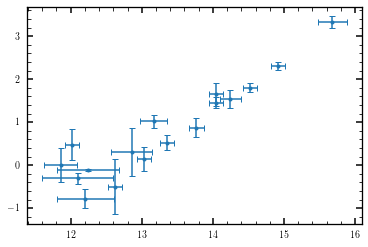

In [28]:
plt.errorbar(data[:, 0], data[:, 1], xerr=xerr, yerr=yerr, fmt='.')

In [273]:
import numpy as np
import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

def model(x, y=None, yerr=0.1, xerr=0.1):
    a = numpyro.sample('a', dist.Uniform(-10, 10))
    b = numpyro.sample('b', dist.Uniform(-50, 50))
    x_obs = numpyro.sample('x_obs', dist.Normal(x, xerr), obs=x)
    y_ = (b + a * x_obs)
#     y_ = (b + a * x)
    # notice that we clamp the outcome of this sampling to the observation y 
    numpyro.sample('obs', dist.Normal(y_, yerr), obs=y)
    
# need to split the key for jax's random implementation
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

In [274]:
# run HMC with NUTS
kernel = NUTS(model, target_accept_prob=0.9)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=8000)
mcmc.run(rng_key_, x=data[:, 0].astype(float), y=data[:, 1].astype(float), 
         yerr=yerr.astype(float), xerr=xerr)
mcmc.print_summary()

sample: 100%|██████████████| 9000/9000 [00:08<00:00, 1068.43it/s, 31 steps of size 5.83e-02. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.96      0.04      0.96      0.89      1.02    982.07      1.00
         b    -11.97      0.53    -11.97    -12.77    -11.06    984.79      1.00

Number of divergences: 0


In [275]:
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi

In [283]:
x0 = np.linspace(11, 16, 300)

In [284]:
samples = mcmc.get_samples()
predictive = Predictive(model, samples)
predictions = predictive(rng_key_, x=x0, xerr=0.2, yerr=0.2)['obs']
predictions = predictions[-3000:]
pred_mean = predictions.mean(axis=0)
pred_hpdi = hpdi(predictions, 0.68)

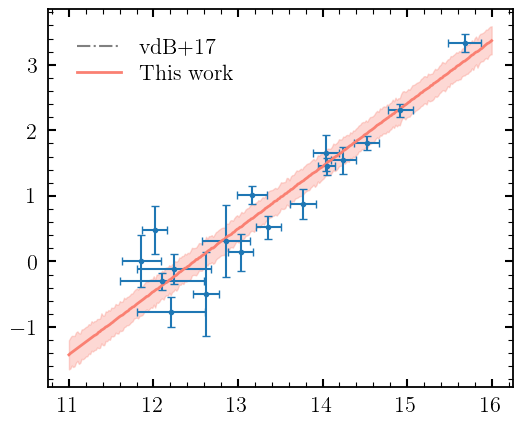

In [285]:
plt.errorbar(data[:, 0], data[:, 1], xerr=xerr, yerr=yerr, fmt='.')

line2 = plt.plot(x0, pred_mean, color='salmon',
                 lw=2, label='This work')
plt.fill_between(
    x0, pred_hpdi[0], pred_hpdi[1], alpha=0.3, color='salmon', interpolate=True)
plt.legend(handles=[line1[0], line2[0]])

### Orthoganle distance regression

In [29]:
from scipy import odr
def f(B, x):
    '''Linear function y = m*x + b'''
    return B[0]*x + B[1]
linear = odr.Model(f)
mydata = odr.RealData(data[:, 0], data[:, 1], sx=xerr, sy=yerr)
myodr = odr.ODR(mydata, linear, beta0=[1, -11])
myoutput = myodr.run()
myoutput.pprint()
beta = myoutput.beta
beta_std = np.sqrt(np.diag(myoutput.cov_beta)) / 2

Beta: [  0.95899925 -12.00766148]
Beta Std Error: [0.07529987 1.05894022]
Beta Covariance: [[ 0.00385226 -0.05405142]
 [-0.05405142  0.76185198]]
Residual Variance: 1.4718796053519412
Inverse Condition #: 0.030422017080547
Reason(s) for Halting:
  Sum of squares convergence


NameError: name 'x0' is not defined

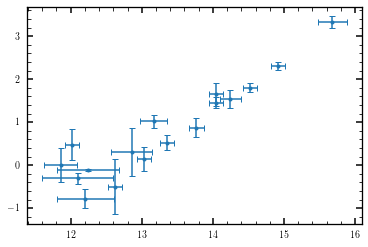

In [30]:
plt.errorbar(data[:, 0], data[:, 1], xerr=xerr, yerr=yerr, fmt='.')

# line2 = plt.plot(x0, pred_mean, color='salmon',
#                  lw=2, label='This work')
# plt.fill_between(
#     x0, pred_hpdi[0], pred_hpdi[1], alpha=0.3, color='salmon', interpolate=True)

plt.plot(x0, f(myoutput.beta, x0))

plt.fill_between(x0, f(beta + beta_std, x0), 
                 f(beta - beta_std, x0), alpha=0.3, color='steelblue', interpolate=True)

x = np.linspace(11.5, 16, 10)
line1 = plt.plot(x, 1.11 * x + np.log10(19) - 1.11 * 14, label='vdB+17', ls='-.', color='gray')
plt.fill_between(x, (1.11 + 0.04) * x + np.log10(19) - 1.11 * 14, 
                 (1.11 - 0.04) * x + np.log10(19) - 1.11 * 14, 
                 alpha=0.2, color='gray', interpolate=True)
plt.legend(handles=[line1[0]], loc='lower right')